In [1]:
from cil.optimisation.functions import Function
from cil.framework import ImageGeometry, AcquisitionGeometry
import numpy                       
import matplotlib.pyplot as plt

from cil.optimisation.algorithms import PDHG, FISTA
from cil.optimisation.operators import GradientOperator, IdentityOperator, BlockOperator
from cil.optimisation.functions import KullbackLeibler, TotalVariation, BlockFunction, IndicatorBox, OperatorCompositionFunction, L2NormSquared, MixedL21Norm
from cil.plugins.ccpi_regularisation.functions import FGP_TV                      
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import plotter2D
from cil.utilities.dataexample import TestData
from SmoothKullbackLeibler import SmoothKullbackLeibler
import os, sys
import tomophantom
from tomophantom import TomoP2D

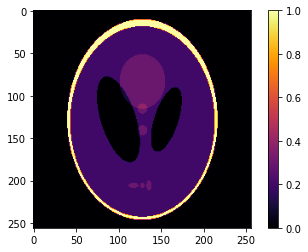

In [3]:
model = 1 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N)

shepp = ig.allocate()
shepp.fill(phantom2D)

plt.figure()
plt.imshow(shepp.as_array(), cmap="inferno")
plt.colorbar()
plt.show()

# Denoising First

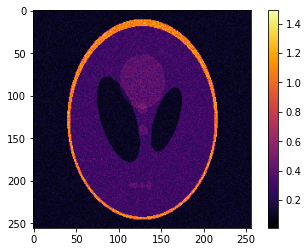

In [4]:
shepp_data = ig.allocate()
shepp_data.fill(phantom2D)

eta = ig.allocate()
eta.fill(0.1)
scale = 100
noisy_shepp_data = ig.allocate()
noisy_shepp_data.fill(numpy.random.poisson((phantom2D + eta.as_array())*scale)/scale)
# noisy_shepp_data.fill(numpy.random.poisson(phantom2D*scale))/scale + eta

plt.figure()
plt.imshow(noisy_shepp_data.as_array(), cmap="inferno")
plt.colorbar()
plt.show()  

# FISTA Denoising

In [5]:
KLfidelity = SmoothKullbackLeibler(b = noisy_shepp_data, eta = eta)

alpha = 0.1

In [6]:
r_iterations = 100
r_tolerance = 1e-7          
r_iso = 1
r_nonneg = 1
r_printing = 0

#%% Setup total-variation (TV)
# TV = FGP_TV(alpha, r_iterations, r_tolerance, r_iso, r_nonneg, r_printing, 'gpu')
TV = alpha * TotalVariation(r_iterations, r_tolerance, lower = 0)

#%% Setup FISTA to solve for TV
fista_TV = FISTA(x_init=ig.allocate(0), f=KLfidelity, g=TV, 
                 max_iteration=1000, update_objective_interval = 200)

#%% Run FISTA
fista_TV.run(verbose=1)

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
Initialised GradientOperator with C backend running with  20  threads
        0       1000         0.217          8.64556e+03
      200       1000         0.171          4.31934e+02
      400       1000         0.179          4.31919e+02
      600       1000         0.178          4.31918e+02
      800       1000         0.177          4.31918e+02
     1000       1000         0.178          4.31918e+02
-------------------------------------------------------
     1000       1000         0.178          4.31918e+02
Stop criterion has been reached.



# PDHG Denoising

In [7]:
# Create operators
op1 = GradientOperator(ig)
op2 = IdentityOperator(ig)

# Create BlockOperator
operator = BlockOperator(op1, op2, shape=(2,1)) 

def new_convex_conjugate(self,x):
    return 0.

MixedL21Norm.convex_conjugate = new_convex_conjugate

# Create functions      
f = BlockFunction(alpha * MixedL21Norm(), KLfidelity) 
g = IndicatorBox(lower=0)

# Compute operator Norm
normK = operator.norm()

# Primal & dual stepsizes
sigma = 1.
tau = 1./(sigma*normK**2)


# Setup and run the PDHG algorithm
pdhg = PDHG(f=f,g=g,operator=operator, tau=tau, sigma=sigma,
            max_iteration = 1000, update_objective_interval = 100)
pdhg.run(verbose=2)


Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.011    8.64556e+03  -7.02319e+01    8.71579e+03


/opt/anaconda3/envs/CIL2_submit/lib/python3.7/site-packages/cil/framework/framework.py:2164: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      100       1000         0.010    4.31970e+02   4.31602e+02    3.67602e-01
      200       1000         0.010    4.31932e+02   4.31870e+02    6.15430e-02
      300       1000         0.010    4.31924e+02   4.31901e+02    2.34708e-02
      400       1000         0.010    4.31922e+02   4.31910e+02    1.15917e-02
      500       1000         0.010    4.31920e+02   4.31914e+02    6.88171e-03
      600       1000         0.010    4.31920e+02   4.31915e+02    4.85339e-03
      700       1000         0.010    4.31919e+02   4.31916e+02    3.47231e-03
      800       1000         0.010    4.31919e+02   4.31916e+02    2.72921e-03
      900       1000         0.010    4.31919e+02   4.31917e+02    2.25275e-03
     1000       1000         0.010    4.31919e+02   4.31917e+02    1.95481e-03
----------------------------------------------------------------------------
     1000       1000         0.010    4.31919e+02   4.31917e+02    1.95481e-03
Stop criterion has been reached.



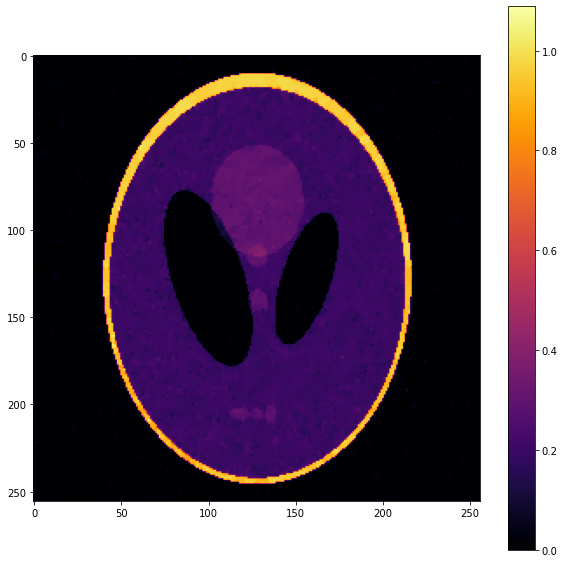

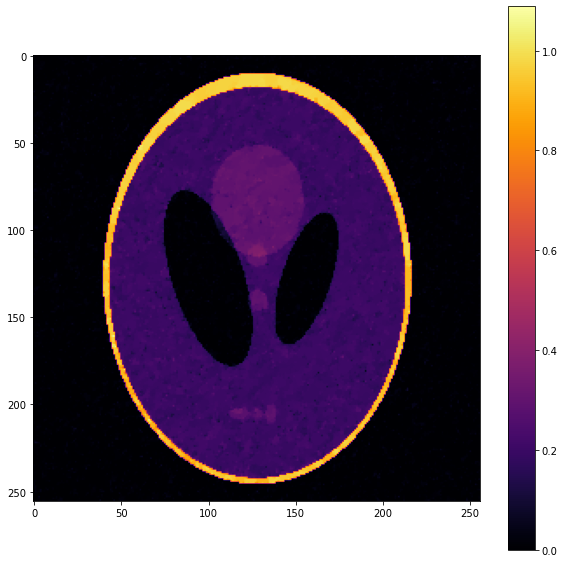

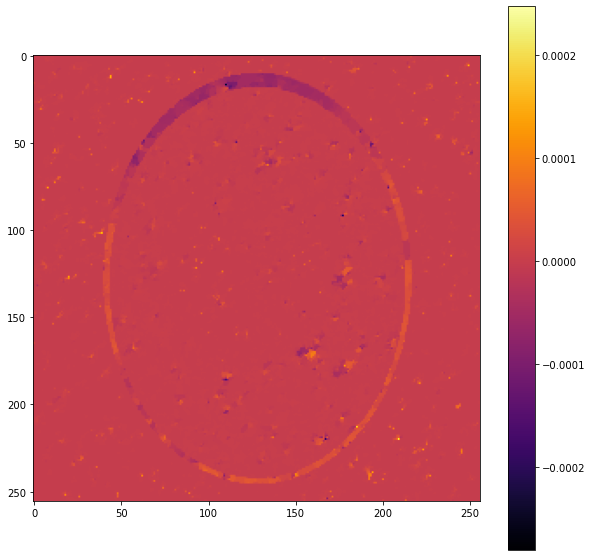

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(pdhg.solution.as_array(), cmap="inferno")
plt.colorbar()
plt.show() 

plt.figure(figsize=(10,10))
plt.imshow(fista_TV.solution.as_array(), cmap="inferno")
plt.colorbar()
plt.show() 

plt.figure(figsize=(10,10))
plt.imshow(pdhg.solution.as_array() - fista_TV.solution.as_array(), cmap="inferno")
plt.colorbar()
plt.show() 

# FISTA/PDHG Tomography reconstruction

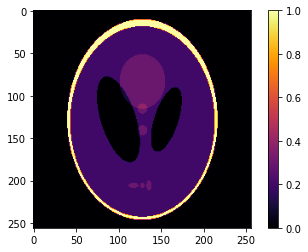

In [3]:
model = 1 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N)

shepp = ig.allocate()
shepp.fill(phantom2D)

plt.figure()
plt.imshow(shepp.as_array(), cmap="inferno")
plt.colorbar()
plt.show()

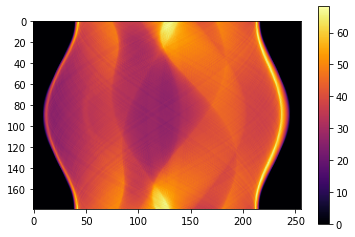

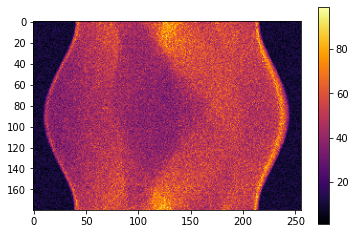

In [6]:
# Create acquisition data and geometry
detectors = N
angles = numpy.linspace(0, numpy.pi, 180)

#%% set up geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                            .set_panel(N)\
                            .set_angles(angles, angle_unit="radian")

ig = ag.get_ImageGeometry()
A = ProjectionOperator(ig, ag)
data = A.direct(shepp)

plt.figure()
plt.imshow(data.as_array(), cmap="inferno")
plt.colorbar()
plt.show()

# Poisson noise

eta_sin = ag.allocate()
eta_sin.fill(10)
scale = 10
noisy_data = ag.allocate()
noisy_data.fill(numpy.random.poisson(scale * (eta_sin.as_array() + data.as_array())/scale))
                
plt.figure()
plt.imshow(noisy_data.as_array(), cmap="inferno")
plt.colorbar()
plt.show()                

In [8]:
KLfidelity = OperatorCompositionFunction(SmoothKullbackLeibler(b = noisy_data, eta = eta_sin), A)

In [10]:
alpha = 10

r_iterations = 100
r_tolerance = 1e-7          
r_iso = 1
r_nonneg = 1
r_printing = 0

#%% Setup total-variation (TV)
# TV = FGP_TV(alpha, r_iterations, r_tolerance, r_iso, r_nonneg, r_printing, 'gpu')
TV = alpha * TotalVariation(r_iterations, r_tolerance, lower = 0)

#%% Setup FISTA to solve for TV
fista_TV_tomo = FISTA(x_init=ig.allocate(0), f=KLfidelity, g=TV, max_iteration=1000,
                      update_objective_interval = 100)

#%% Run FISTA
fista_TV_tomo.run(1000,verbose=1)

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
Initialised GradientOperator with C backend running with  20  threads
        0       1000         0.213          1.51320e+06
      100       1000         0.174          3.46486e+04
      200       1000         0.173          3.34348e+04
      300       1000         0.173          3.34009e+04
      400       1000         0.172          3.33939e+04
      500       1000         0.171          3.33917e+04
      600       1000         0.170          3.33908e+04
      700       1000         0.169          3.33904e+04
      800       1000         0.169          3.33902e+04
      900       1000         0.169          3.33901e+04
     1000       1000         0.169          3.33900e+04
-------------------------------------------------------
     1000       1000         0.169          3.33900e+04
Stop criterion has been reached.



In [30]:
# Create operators
alpha = 10
# op1 = GradientOperator(ig)
op2 = A

# Create BlockOperator
# operator = BlockOperator(op1, op2, shape=(2,1)) 
operator = op2

def new_convex_conjugate(self,x):
    return 0.

MixedL21Norm.convex_conjugate = new_convex_conjugate

# Create functions      
# f = BlockFunction(alpha * MixedL21Norm(), SmoothKullbackLeibler(b = noisy_data, eta = eta_sin)) 
f = SmoothKullbackLeibler(b = noisy_data, eta = eta_sin) 
# g = IndicatorBox(lower=0)
g = alpha * TotalVariation(r_iterations, r_tolerance, lower = 0)

# Compute operator Norm
normK = operator.norm()

# Primal & dual stepsizes
sigma = 5.
tau = 1./(sigma*normK**2)


# Setup and run the PDHG algorithm
pdhg_TV_tomo = PDHG(f=f,g=g,operator=operator, tau=tau, sigma=sigma,
            max_iteration = 10000, update_objective_interval = 500)
pdhg_TV_tomo.run(verbose=2)


Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0      10000         0.022    1.51320e+06  -1.78107e+03    1.51498e+06
      500      10000         0.020    8.28245e+04  -4.36598e+05    5.19423e+05
     1000      10000         0.020    5.91766e+04  -1.68890e+05    2.28067e+05
     1500      10000         0.020    4.98414e+04  -8.26139e+04    1.32455e+05
     2000      10000         0.021    4.50527e+04  -4.24534e+04    8.75060e+04
     2500      10000         0.021    4.21533e+04  -2.17779e+04    6.39312e+04
     3000      10000         0.021    4.02259e+04  -9.83048e+03    5.00563e+04
     3500      10000         0.021    3.88704e+04  -2.00996e+03    4.08803e+04
     4000      10000         0.021    3.78726e+04   3.79016e+03    3.40824e+04
     4500      10000         

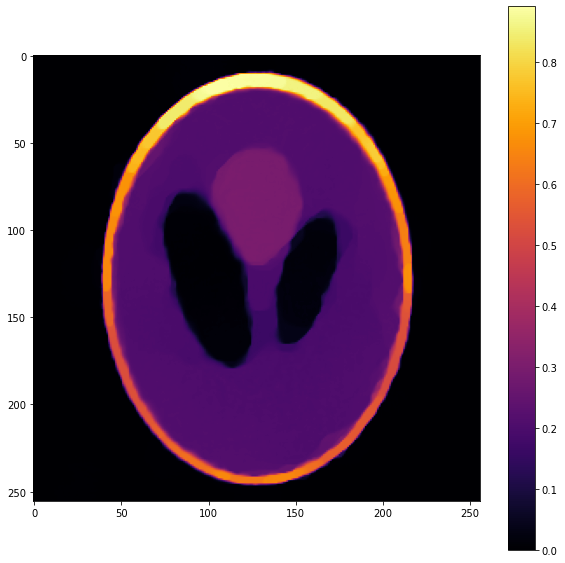

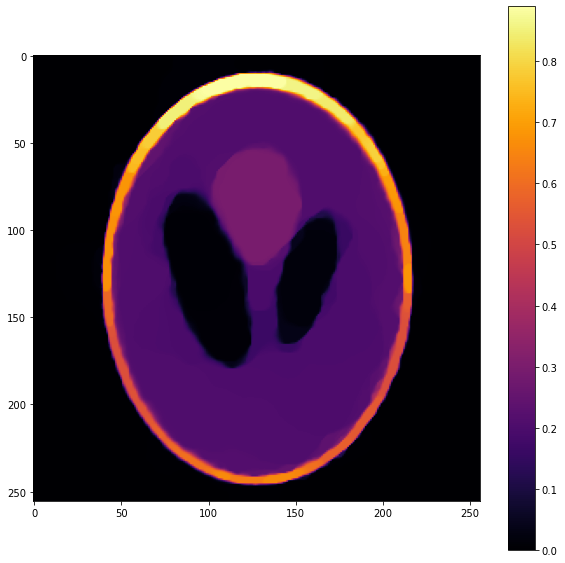

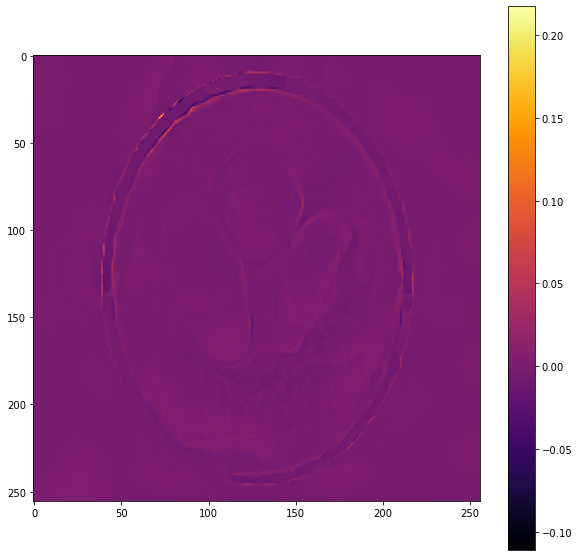

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(pdhg_TV_tomo.solution.as_array(), cmap="inferno")
plt.colorbar()
plt.show() 

plt.figure(figsize=(10,10))
plt.imshow(fista_TV_tomo.solution.as_array(), cmap="inferno")
plt.colorbar()
plt.show() 

plt.figure(figsize=(10,10))
plt.imshow(pdhg_TV_tomo.solution.as_array() - fista_TV_tomo.solution.as_array(), cmap="inferno")
plt.colorbar()
plt.show() 

In [27]:
from cil.optimisation.algorithms import Algorithm
from cil.optimisation.functions import ZeroFunction
import numpy
import warnings

class FISTA_backtracking(Algorithm):

    
    def __init__(self, initial=None, f=None, g=ZeroFunction(), **kwargs):
                
        super(FISTA_backtracking, self).__init__(**kwargs)
        if kwargs.get('x_init', None) is not None:
            if initial is None:
                warnings.warn('The use of the x_init parameter is deprecated and will be removed in following version. Use initial instead',
                   DeprecationWarning, stacklevel=4)
                initial = kwargs.get('x_init', None)
            else:
                raise ValueError('{} received both initial and the deprecated x_init parameter. It is not clear which one we should use.'\
                    .format(self.__class__.__name__))
        
        if initial is not None and f is not None:
            self.set_up(initial=initial, f=f, g=g)

    def set_up(self, initial, f, g=ZeroFunction()):

        print("{} setting up".format(self.__class__.__name__, ))
        
        self.y = initial.copy()
        self.x_old = initial.copy()
        self.x = initial.copy()
        self.u = initial.copy()

        self.f = f
        self.g = g
        if f.L is None:
            raise ValueError('Error: Fidelity Function\'s Lipschitz constant is set to None')
        self.invL = 1/f.L
        self.t = 1
        self.configured = True
        print("{} configured".format(self.__class__.__name__, ))

            
    def update(self):
        
        Lbar = self.f.L
        backtrack = 1
        while backtrack:
            
            self.g.proximal(self.u, self.invL, out=self.x)
            
#             self.invL_bar = 1/Lbar
            
            F = self.f(self.x_old)
            Q = self.f(self.y) + (self.x_old - self.y).dot(self.f.gradient(self.y)) + Lbar/2 * ((self.x_old - self.y)**2).sum()
#             print(F, Q)
            
            
#        f = self.obfn_f(self.var_x())
#             Dxy = self.eval_Dxy()
#             Q = self.obfn_f(self.var_y()) + \
#                 self.eval_linear_approx(Dxy, gradY) + \
#                 (self.L / 2.) * np.linalg.norm(Dxy.flatten(), 2)**2            
            
            if F<=Q:
                backtrack = 0
            else:    
                Lbar*=10
# #             print(Lbar)
#             L = Lbar
# #             print(L)
            self.invL = 1/Lbar
    

#         print(self.invL)
        self.t_old = self.t
        self.f.gradient(self.y, out=self.u)
        self.u.__imul__( -self.invL )
        self.u.__iadd__( self.y )

        self.g.proximal(self.u, self.invL, out=self.x)
        
        self.t = 0.5*(1 + numpy.sqrt(1 + 4*(self.t_old**2)))
        
        self.x.subtract(self.x_old, out=self.y)
        self.y.axpby(((self.t_old-1)/self.t), 1, self.x, out=self.y)
        
        self.x_old.fill(self.x)

        
    def update_objective(self):
        self.loss.append( self.f(self.x) + self.g(self.x) )    
    


In [28]:
#%% Setup FISTA to solve for TV
fista_TV_tomo_back = FISTA_backtracking(x_init=ig.allocate(0), f=KLfidelity, g=TV, max_iteration=1000,
                      update_objective_interval = 100)

#%% Run FISTA
fista_TV_tomo_back.run(1000,verbose=1)

FISTA_backtracking setting up
FISTA_backtracking configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.113          3.24853e+06
      100       1000         0.083          1.21586e+05
      200       1000         0.081          5.75235e+04
      300       1000         0.079          4.30384e+04
      400       1000         0.079          3.82850e+04
      500       1000         0.079          3.64538e+04
      600       1000         0.079          3.57306e+04
      700       1000         0.079          3.54517e+04
      800       1000         0.080          3.53061e+04
      900       1000         0.080          3.52889e+04
     1000       1000         0.080          3.53042e+04
-------------------------------------------------------
     1000       1000         0.080          3.53042e+04
Stop criterion has been reached.



In [29]:
#%% Setup FISTA to solve for TV
fista_TV_less_iter = FISTA(x_init=ig.allocate(0), f=L2fidelity, g=TV, max_iteration=100)
fista_TV_less_iter.update_objective_interval = 1

#%% Run FISTA
fista_TV_less_iter.run(verbose=0)

FISTA setting up
FISTA configured


In [35]:
Fstar = TV(fista_TV.solution) + L2fidelity(fista_TV.solution)
print(Fstar)
plt.figure()
plt.plot(fista_TV_less_iter.objective - 100000.)
plt.show()

280.0650939941406


TypeError: unsupported operand type(s) for -: 'list' and 'float'

<Figure size 432x288 with 0 Axes>

In [12]:
#%%
reco = fista_TV.solution

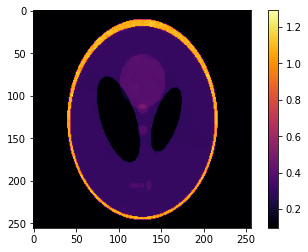

FISTA with Backtracking

In [11]:
from cil.optimisation.algorithms import Algorithm
from cil.optimisation.functions import ZeroFunction
import numpy
import warnings

class FISTA_backtracking(Algorithm):
    
    r'''Fast Iterative Shrinkage-Thresholding Algorithm 
    
    Problem : 
    
    .. math::
    
      \min_{x} f(x) + g(x)
    
    |
    
    Parameters :
        
      :param initial: Initial guess ( Default initial = 0)
      :param f: Differentiable function
      :param g: Convex function with " simple " proximal operator


    Reference:
      
        Beck, A. and Teboulle, M., 2009. A fast iterative shrinkage-thresholding 
        algorithm for linear inverse problems. 
        SIAM journal on imaging sciences,2(1), pp.183-202.
    '''
    
    
    def __init__(self, initial=None, f=None, g=ZeroFunction(), **kwargs):
        
        '''FISTA algorithm creator 
        
        initialisation can be done at creation time if all 
        proper variables are passed or later with set_up
        
        Optional parameters:

        :param initial: Initial guess ( Default initial = 0)
        :param f: Differentiable function
        :param g: Convex function with " simple " proximal operator'''
        
        super(FISTA_backtracking, self).__init__(**kwargs)
        if kwargs.get('x_init', None) is not None:
            if initial is None:
                warnings.warn('The use of the x_init parameter is deprecated and will be removed in following version. Use initial instead',
                   DeprecationWarning, stacklevel=4)
                initial = kwargs.get('x_init', None)
            else:
                raise ValueError('{} received both initial and the deprecated x_init parameter. It is not clear which one we should use.'\
                    .format(self.__class__.__name__))
        
        if initial is not None and f is not None:
            self.set_up(initial=initial, f=f, g=g)

    def set_up(self, initial, f, g=ZeroFunction()):
        '''initialisation of the algorithm

        :param initial: Initial guess ( Default initial = 0)
        :param f: Differentiable function
        :param g: Convex function with " simple " proximal operator'''

        print("{} setting up".format(self.__class__.__name__, ))
        
        self.y = initial.copy()
        self.x_old = initial.copy()
        self.x = initial.copy()
        self.u = initial.copy()

        self.f = f
        self.g = g
        if f.L is None:
            raise ValueError('Error: Fidelity Function\'s Lipschitz constant is set to None')
        self.invL = 1/f.L
        self.t = 1
        self.configured = True
        print("{} configured".format(self.__class__.__name__, ))

            
    def update(self):
        
        Lbar = self.f.L
        while True:
            
            self.invL_bar = 1/Lbar
            zk = self.g.proximal(self.u, self.invL_bar)
            F = self.f(zk) + self.g(zk)
            Q = self.f(self.y) + (self.x - self.y).dot(self.f.gradient(self.y)) + Lbar/2 * (self.x - self.y).squared_norm() + self.g(self.x)
#             print(F, Q)
            if F<=Q:
                break
            Lbar*=2
            L = Lbar
#             print(L)
            self.invL = 1/L
       
        self.t_old = self.t
        self.f.gradient(self.y, out=self.u)
        self.u.__imul__( -self.invL )
        self.u.__iadd__( self.y )

        self.g.proximal(self.u, self.invL, out=self.x)
        
        self.t = 0.5*(1 + numpy.sqrt(1 + 4*(self.t_old**2)))
        
        self.x.subtract(self.x_old, out=self.y)
        self.y.axpby(((self.t_old-1)/self.t), 1, self.x, out=self.y)
        
        self.x_old.fill(self.x)

        
    def update_objective(self):
        self.loss.append( self.f(self.x) + self.g(self.x) )    
    


In [19]:
alpha = 0.1

r_iterations = 100
r_tolerance = 1e-7          
r_iso = 1
r_nonneg = 1
r_printing = 0

#%% Setup total-variation (TV)
TV = FGP_TV(alpha, r_iterations, r_tolerance, r_iso, r_nonneg, r_printing, 'gpu')


L2fidelity.L = 100
#%% Setup FISTA to solve for TV
fista_TV_back = FISTA_backtracking(x_init=ig.allocate(0), f=L2fidelity, g=TV, max_iteration=1000)
fista_TV_back.update_objective_interval = 5

#%% Run FISTA
fista_TV_back.run(100, verbose=1)

FISTA_backtracking setting up
FISTA_backtracking configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.100          6.44824e+03
        5       1000         0.078          4.98555e+03
       10       1000         0.079          2.97291e+03
       15       1000         0.079          1.33512e+03
       20       1000         0.077          4.94093e+02
       25       1000         0.076          2.81611e+02
       30       1000         0.076          3.13003e+02
       35       1000         0.076          3.36533e+02
       40       1000         0.076          3.10429e+02
       45       1000         0.076          2.83554e+02
       50       1000         0.076          2.80882e+02
       55       1000         0.076          2.87862e+02
       60       1000         0.076          2.87997e+02
       65       1000         0.076          2.82546e+02
       70       1000         0.075          